In [78]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

import statsmodels.formula.api as smf
import statsmodels.api as sm

### Informative scores across perturbed pathways

In [130]:
data2 = pd.read_csv('../results/benchmark/z_scores/progeny/single/KEGG_filtered_abs.csv',
                  sep=',', header=0, index_col=0)
data1 = pd.read_csv('../results/benchmark/z_scores/progeny/single/BEST_dorothea_AB_filtered_abs.csv',
                   sep=',', header=0, index_col=0)

In [131]:
data1['Gene set'] = data1.index
data1 = pd.melt(data1, id_vars='Gene set', value_vars=data1.columns[:-1], var_name='Perturbed pathway', 
       value_name='Informative score')
data2['Gene set'] = data2.index
data2 = pd.melt(data2, id_vars='Gene set', value_vars=data2.columns[:-1], var_name='Perturbed pathway', 
       value_name='Informative score')
data1['Database'] = 'DoRothEA'
data2['Database'] = 'KEGG'
data = pd.concat([data1, data2])
data['Informative score'] = data['Informative score'].abs()

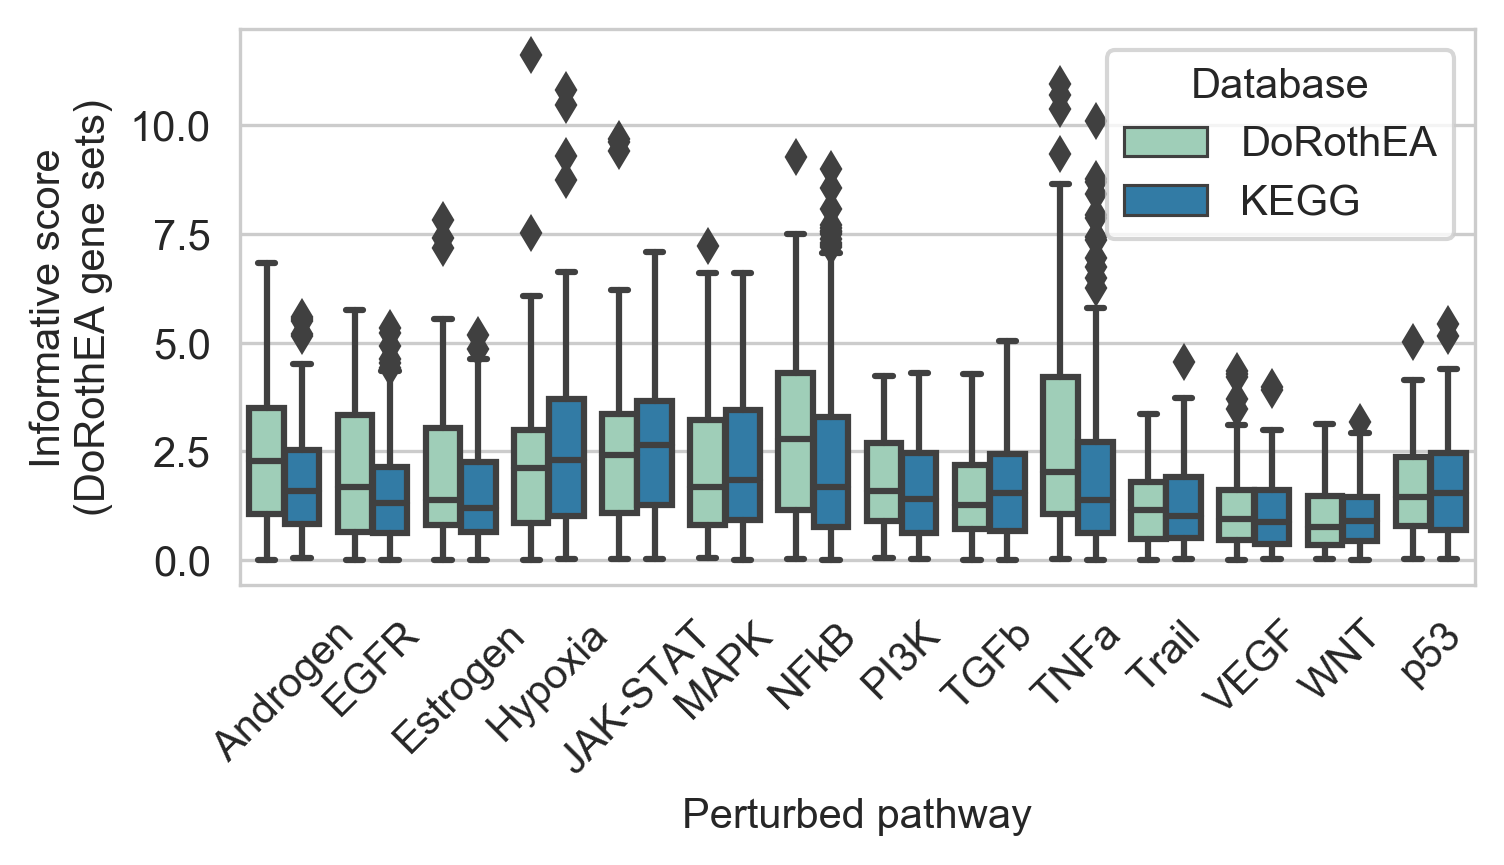

In [133]:
plt.figure(figsize=(5,3), dpi=300)
sns.set_palette('YlGnBu', 2)
sns.boxplot(x=data['Perturbed pathway'], y=data['Informative score'], hue=data['Database'])
plt.ylabel('Informative score\n(DoRothEA gene sets)')
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig('../figures/revision/scores_perturbation.png')

In [139]:
data.columns = ['Gene_set', 'Perturbed_pathway','Informative_score', 'Database']

In [141]:
model = smf.ols('Informative_score ~ Database * Perturbed_pathway', data=data).fit()

In [142]:
sm.stats.anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
Database,1.0,29.139363,29.139363,13.524107,2.385886e-04
Perturbed_pathway,13.0,1091.223624,83.940279,38.958206,7.821004e-94
Database:Perturbed_pathway,13.0,116.738473,8.979883,4.167726,6.314308e-07
Residual,4032.0,8687.443315,2.154624,NaN,NaN


### TF mutations in GDSC benchmark data

In [154]:
data = pd.read_csv('../results/benchmark/z_scores/gdsc/single/BEST_dorothea_AB_filtered.csv',
                  sep=',', header=0, index_col=0)

In [155]:
mutations = pd.Series(data.columns).apply(lambda x: x.split('_')[0])

In [156]:
tfs = pd.read_csv('../results/genesets/single/csvs/dorothea_ABCDE.csv', sep=',', header=0, index_col=0)

/Users/benceszalai/opt/anaconda3/envs/pycharm/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [157]:
len(set(tfs['Set']) & set(mutations))

27

In [158]:
len(mutations)

172